In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
os.getcwd()

'C:\\Users\\kesha\\Desktop\\Projects\\Audio Recognition'

In [3]:
# Import the Speech Commands dataset
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
    'mini_speech_commands.zip',
    origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
    extract=True,
    cache_dir='.', cache_subdir='data')

In [4]:
# Check basic statistics about the dataset.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
# Extract the audio files into a list and shuffle it.
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\stop\\b5d1e505_nohash_0.wav', shape=(), dtype=string)


In [6]:
filenames[0:10]

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'data\\mini_speech_commands\\stop\\b5d1e505_nohash_0.wav',
       b'data\\mini_speech_commands\\right\\ea356919_nohash_0.wav',
       b'data\\mini_speech_commands\\stop\\f33660af_nohash_1.wav',
       b'data\\mini_speech_commands\\right\\763188c4_nohash_0.wav',
       b'data\\mini_speech_commands\\left\\4c4d2526_nohash_0.wav',
       b'data\\mini_speech_commands\\down\\1e412fac_nohash_0.wav',
       b'data\\mini_speech_commands\\stop\\b959cd0c_nohash_3.wav',
       b'data\\mini_speech_commands\\down\\8ed25ef8_nohash_1.wav',
       b'data\\mini_speech_commands\\up\\c0445658_nohash_3.wav',
       b'data\\mini_speech_commands\\no\\215699ff_nohash_0.wav'],
      dtype=object)>

In [7]:
# Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [8]:
# Reading audio files and their labels
# The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

# To load an audio file, you will use tf.audio.decode_wav, which returns the WAV-encoded audio as a Tensor and the sample rate.

# A WAV file contains time series data with a set number of samples per second. Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in mini_speech_commands, the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. Note that tf.audio.decode_wav will normalize the values to the range [-1.0, 1.0].

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

# The label for each WAV file is its parent directory.

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

# Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [9]:
# You will now apply process_path to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

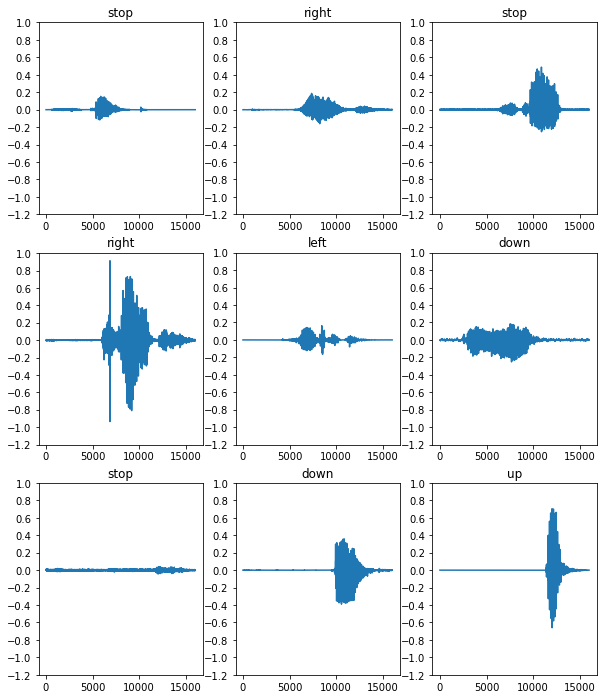

In [10]:
# Let's examine a few audio waveforms with their corresponding labels.

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. The STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying tf.abs on the output of tf.signal.stft.

Choose frame_length and frame_step parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to this video on audio signal processing.

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.

In [11]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [12]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


In [13]:
waveform

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-3.0517578e-05,  0.0000000e+00, -3.0517578e-05, ...,
        0.0000000e+00,  0.0000000e+00, -6.1035156e-05], dtype=float32)>

In [14]:
spectrogram

<tf.Tensor: shape=(124, 129), dtype=float32, numpy=
array([[1.6726665e-04, 2.9044654e-04, 3.1454914e-04, ..., 1.0704274e-04,
        3.1422092e-05, 3.4991928e-05],
       [2.2994357e-04, 5.7032087e-04, 6.1772624e-04, ..., 1.0379490e-04,
        5.0503517e-05, 2.8506300e-05],
       [7.4619398e-05, 4.8312775e-04, 4.3083701e-04, ..., 7.2679577e-05,
        3.3941251e-05, 1.1059776e-05],
       ...,
       [1.4851155e-04, 2.5647329e-04, 3.2658566e-04, ..., 1.0061253e-04,
        9.5462878e-05, 4.0220570e-05],
       [1.2577177e-04, 2.1760455e-04, 1.5151866e-04, ..., 6.8173460e-05,
        5.9165111e-05, 5.5860008e-05],
       [9.4858471e-05, 1.2548942e-04, 1.9415419e-04, ..., 3.3096872e-05,
        6.5654443e-05, 5.8891390e-05]], dtype=float32)>

<ipython-input-15-544266338ef3>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


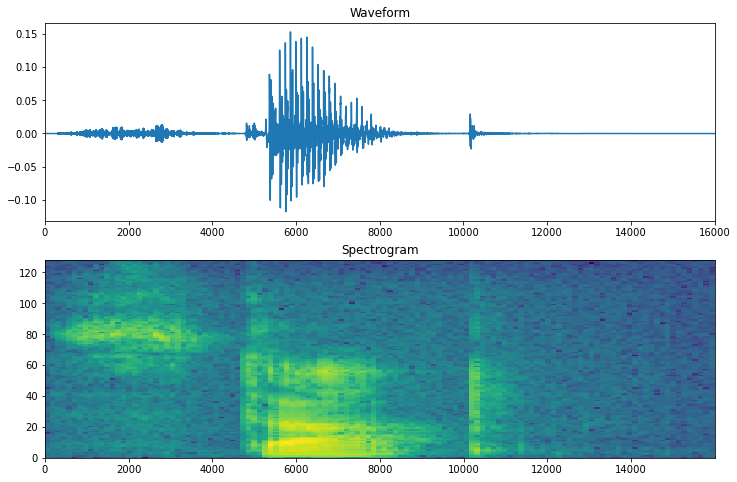

In [15]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [16]:
# Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [17]:
test_spec, test_label = get_spectrogram_and_label_id(waveform, label)
print(test_spec)
print(test_label)

tf.Tensor(
[[[1.6726665e-04]
  [2.9044654e-04]
  [3.1454914e-04]
  ...
  [1.0704274e-04]
  [3.1422092e-05]
  [3.4991928e-05]]

 [[2.2994357e-04]
  [5.7032087e-04]
  [6.1772624e-04]
  ...
  [1.0379490e-04]
  [5.0503517e-05]
  [2.8506300e-05]]

 [[7.4619398e-05]
  [4.8312775e-04]
  [4.3083701e-04]
  ...
  [7.2679577e-05]
  [3.3941251e-05]
  [1.1059776e-05]]

 ...

 [[1.4851155e-04]
  [2.5647329e-04]
  [3.2658566e-04]
  ...
  [1.0061253e-04]
  [9.5462878e-05]
  [4.0220570e-05]]

 [[1.2577177e-04]
  [2.1760455e-04]
  [1.5151866e-04]
  ...
  [6.8173460e-05]
  [5.9165111e-05]
  [5.5860008e-05]]

 [[9.4858471e-05]
  [1.2548942e-04]
  [1.9415419e-04]
  ...
  [3.3096872e-05]
  [6.5654443e-05]
  [5.8891390e-05]]], shape=(124, 129, 1), dtype=float32)
tf.Tensor(5, shape=(), dtype=int64)


In [18]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

<ipython-input-15-544266338ef3>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


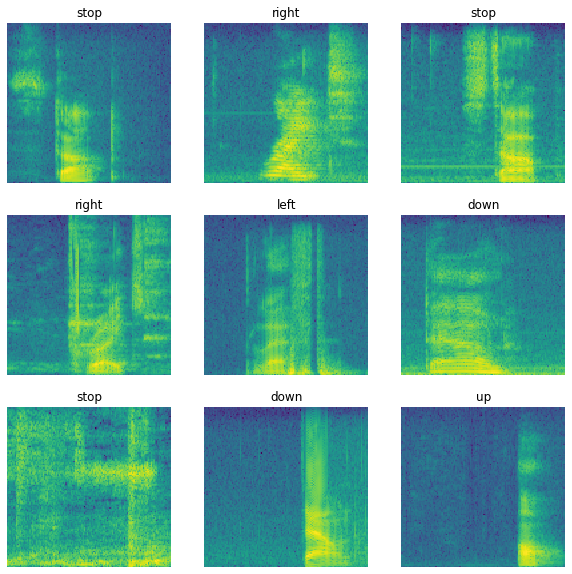

In [19]:
# Examine the spectrogram "images" for different samples of the dataset.
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [20]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [21]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [22]:
# Batch the training and validation sets for model training.
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [23]:
# Add dataset cache() and prefetch() operations to reduce read latency while training the model.
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images. The model also has the following additional preprocessing layers:

    1. A Resizing layer to downsample the input to enable the model to train faster.
    2. A Normalization layer to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [24]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [26]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 41s 119ms/step - loss: 1.9055 - accuracy: 0.2816 - val_loss: 1.3729 - val_accuracy: 0.5788
Epoch 2/10
100/100 [==============================] - 2s 23ms/step - loss: 1.2916 - accuracy: 0.5520 - val_loss: 0.9768 - val_accuracy: 0.7088
Epoch 3/10
100/100 [==============================] - 2s 23ms/step - loss: 0.9689 - accuracy: 0.6490 - val_loss: 0.7897 - val_accuracy: 0.7387
Epoch 4/10
100/100 [==============================] - 2s 23ms/step - loss: 0.7934 - accuracy: 0.7200 - val_loss: 0.7030 - val_accuracy: 0.7675
Epoch 5/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6778 - accuracy: 0.7657 - val_loss: 0.6562 - val_accuracy: 0.7837
Epoch 6/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6060 - accuracy: 0.7819 - val_loss: 0.6169 - val_accuracy: 0.7950
Epoch 7/10
100/100 [==============================] - 2s 23ms/step - loss: 0.5344 - accuracy: 0.8122 - val_loss: 0.5834 - val_accuracy: 0.81

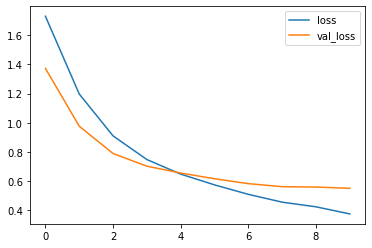

In [27]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [28]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [31]:
print(test_audio.shape)
print(test_audio[0])

(800, 124, 129, 1)
[[[1.08990613e-02]
  [4.70824838e-02]
  [4.99518253e-02]
  ...
  [9.62550766e-05]
  [1.17856849e-04]
  [1.10077206e-04]]

 [[1.10769691e-02]
  [2.72957385e-02]
  [4.40360233e-02]
  ...
  [1.38567091e-04]
  [1.04399594e-04]
  [4.68241051e-05]]

 [[1.02034016e-02]
  [1.02488697e-01]
  [1.52551100e-01]
  ...
  [1.66273330e-05]
  [6.19321363e-05]
  [2.62307003e-05]]

 ...

 [[4.96790074e-02]
  [1.12703770e-01]
  [1.35047063e-01]
  ...
  [4.54311194e-05]
  [5.44010181e-05]
  [5.51007688e-05]]

 [[6.27446026e-02]
  [1.33993551e-01]
  [9.11282673e-02]
  ...
  [7.18485971e-05]
  [1.20924953e-04]
  [1.31934881e-04]]

 [[3.93248303e-03]
  [9.91239697e-02]
  [8.59304145e-02]
  ...
  [2.52252066e-05]
  [5.00194801e-05]
  [3.14177014e-05]]]


In [32]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 83%


## Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

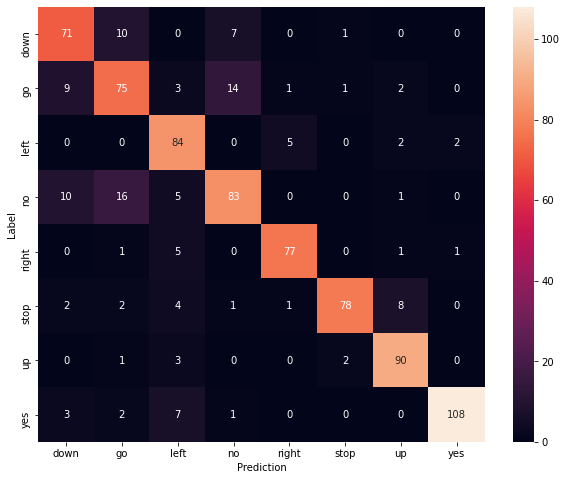

In [35]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does your model perform?

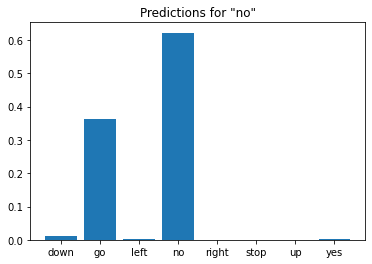

In [36]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()